# Relation Classification - torch version

目的是为了做出spo联合抽取的pipeline的第一步，也就是rc，其本质上为一个多标签文本分类，分出文本属于哪几类，这里的是所有torch的方法来做这个事情的实验合集

## Dive version

文本的常见预处理步骤

    将文本作为字符串加载到内存中。
    将字符串拆分为标记（如，单词和字符）。
    建立一个词汇表，将拆分的标记映射到数字索引。
    将文本转换为数字索引序列，以便模型可以轻松地对其进行操作。

In [99]:
import collections
import re
import fanTools
from d2l import torch as d2l
import torch

In [33]:
import os
os.getcwd()

'D:\\kwCodes\\REcodes'

In [34]:
bert_path = "./pretrained_model/chinese_roberta_wwm_ext_pytorch/"

### 数据预处理

In [2]:
# 文本分类数据集路径
posdata_path = './re_datasets/clothing_comment_情感分析/posdata.txt'
negdata_path = './re_datasets/clothing_comment_情感分析/negdata.txt'

In [3]:
# 读入数据集
pos_list = fanTools.read_file_to_list(posdata_path)
neg_list = fanTools.read_file_to_list(negdata_path)
print('positive instance',pos_list[0])
print('negative instance',neg_list[0])
len(pos_list), len(neg_list)

positive instance 质量好,做工也不错,尺码标准,
negative instance 穿上不舒服，颜色和质感跟图片差异很大，建议慎重购买！后悔了！


(1500, 1500)

In [46]:
import sys
sys.getsizeof(pos_list), sys.getsizeof(neg_list)

(13008, 13008)

若需要去噪，可以用str.replace也可以用regex

In [61]:
from string import punctuation
punc = punctuation + u'.,;《》？！“”‘’@#￥%…&×（）——+【】{};；●，。&～、|\s:：'
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~.,;《》？！“”‘’@#￥%…&×（）——+【】{};；●，。&～、|\\s:：'

In [65]:
def rm_marks(str):
    str1 = re.sub(r"[{}]".format(punc),'',str)
    return str1

### 标记化(Tokenize) - 分词

可以以词为级别的分词(用jieba),也可以直接用字符级别

In [66]:
import jieba
def tokenize(lines):
    return [list(jieba.cut(rm_marks(line))) for line in lines]

In [67]:
all_sentences = pos_list+neg_list
tokens = tokenize(all_sentences)
len(tokens)

3000

在这里tokens是一个巨大的list，每一个list都是句子被tokenize后的一个list，也是个矩阵

### 构建词表(vocab)

模型需要的输入是数字。我们构建一个字典，通常也叫做词表（vocabulary），用来将字符串标记映射到从0开始的数字索引中。
首先统计训练集中所有文档中唯一的标记，称之为 语料（corpus），然后根据每个唯一标记的出现频率为其分配一个数字索引。很少出现的标记通常被移除，这可以降低复杂性。语料库中不存在或已删除的任何标记都将映射到一个特定的未知标记 “\<unk>” 。我们可以选择增加一个列表，用于保存保留的标记，例如“\<pad>”表示填充；“\<bos>”表示序列的开始；“\<eos>”表示序列的结束

In [53]:
class Vocab:  
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # 未知标记的索引为0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  #@save
    """统计标记的频率。"""
    # 这里的 `tokens` 是 1D 列表或 2D 列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将标记列表展平成使用标记填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [83]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:20])

[('<unk>', 0), ('的', 1), ('很', 2), ('了', 3), ('好', 4), ('质量', 5), ('不错', 6), ('裤子', 7), ('也', 8), ('穿', 9), ('买', 10), ('不', 11), ('我', 12), ('是', 13), ('还', 14), ('舒服', 15), ('衣服', 16), ('都', 17), ('就', 18), ('喜欢', 19)]


将每一行文本转换成一个数字索引列表

In [74]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['质量', '好', '做工', '也', '不错', '尺码', '标准']
indices: [5, 4, 52, 8, 6, 63, 213]
words: ['宝贝', '收到', '了', '试', '了', '一下', '穿', '上', '挺舒服', '的', '是', '正品', '综合', '给', '好评']
indices: [81, 24, 3, 427, 3, 104, 9, 22, 204, 1, 13, 198, 1474, 20, 50]


In [92]:
corpus = [token for line in tokens for token in line]
print(len(corpus))
corpus[:10]

49153


['质量', '好', '做工', '也', '不错', '尺码', '标准', '裤子', '质量', '很']

### 自然语言统计

[('的', 2595), ('很', 1851), ('了', 1718), ('好', 1029), ('质量', 976), ('不错', 956), ('裤子', 935), ('也', 859), ('穿', 721), ('买', 711)]


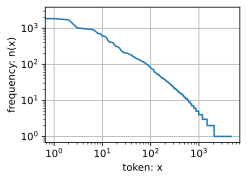

In [87]:
%matplotlib inline
print(vocab.token_freqs[:10])
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

事实上最流行的词看起来很无聊。它们通常被称为“停用词”（stop words），因此可以被过滤掉。尽管如此，它们仍然有意义，我们仍然会使用它们。此外，显而易见的是词频衰减的速度得相当地快。第  10  个最常用单词的词频还不到最流行单词词频的  1/5 。词频以一种明确的方式迅速衰减。将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。这说明单词符合齐普夫定律
                        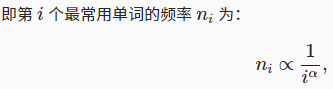
                        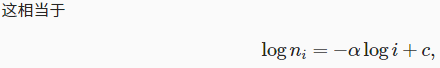


用n-gram语法:bigram和trigram试试

In [89]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
print(bigram_tokens[:10])
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('质量', '好'), ('好', '做工'), ('做工', '也'), ('也', '不错'), ('不错', '尺码'), ('尺码', '标准'), ('标准', '裤子'), ('裤子', '质量'), ('质量', '很'), ('很', '好')]


[(('很', '好'), 493),
 (('很', '舒服'), 257),
 (('质量', '不错'), 233),
 (('穿', '上'), 205),
 (('也', '很'), 195),
 (('买', '的'), 195),
 (('质量', '很'), 184),
 (('很', '喜欢'), 176),
 (('裤子', '质量'), 165),
 (('的', '裤子'), 158)]

In [93]:
trigram_tokens = [
    triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('质量', '很', '好'), 148),
 (('穿', '上', '很'), 120),
 (('上', '很', '舒服'), 90),
 (('的', '一次', '购物'), 72),
 (('也', '很', '好'), 69),
 (('挺', '好', '的'), 61),
 (('裤子', '质量', '很'), 58),
 (('穿', '起来', '很'), 43),
 (('裤子', '收到', '了'), 42),
 (('收到', '了', '质量'), 42)]

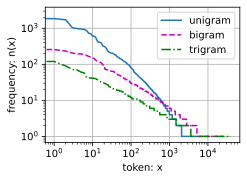

In [94]:
# 最后，让我们直观地看一下这三种模型中的标记频率：单字、双字和三字。
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

首先，除了单字词，单词序列似乎也遵循齐普夫定律。其次，词典中  n  元组的数量并没有那么大，说明语言中存在相当多的结构，这给了我们应用模型希望。第三，很多  n  元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。作为代替，我们将使用基于深度学习的模型。

## 正文 - 基于bert

1.导库

In [110]:
import pandas as pd 
import numpy as np 
import json, time 
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore') # 过滤warning

bert_path = "./pretrained_model/chinese_roberta_wwm_ext_pytorch/"
# posdata_path = './re_datasets/clothing_comment_情感分析/posdata.txt'
# negdata_path = './re_datasets/clothing_comment_情感分析/negdata.txt'
data_path = "./re_datasets/THUCNews/news_title_dataset.csv"
tokenizer = BertTokenizer.from_pretrained(bert_path)   # 初始化分词器

2.数据预处理

In [ ]:
input_ids, input_masks, input_types,  = [], [], []  # input char ids, segment type ids,  attention mask
labels = []         # 标签
maxlen = 30      # 取30即可覆盖99%
 
with open(data_path, encoding='utf-8') as f:
    for i, line in tqdm(enumerate(f)): 
        title, y = line.strip().split('\t')

        # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
        # 根据参数会短则补齐，长则切断
        encode_dict = tokenizer.encode_plus(text=title, max_length=maxlen, 
                                            padding='max_length', truncation=True)
        
        input_ids.append(encode_dict['input_ids'])
        input_types.append(encode_dict['token_type_ids'])
        input_masks.append(encode_dict['attention_mask'])

        labels.append(int(y))

input_ids, input_types, input_masks = np.array(input_ids), np.array(input_types), np.array(input_masks)
labels = np.array(labels)
print(input_ids.shape, input_types.shape, input_masks.shape, labels.shape)

In [2]:
import difflib
a="阿里巴巴达摩院"
b="阿里巴巴"
score = difflib.SequenceMatcher(None,a,b).ratio()
score

0.7272727272727273